# Can we model the optical interference caused by the MIRI detectors?
We have accumulated quite some information thus far on the optical properties of the MIRI detector layers. How can we use these as inputs to model the intrinsic fringe transmission of the SW detector? The approach here is to solve the Fresnel continuity equations assuming a plane-parallel medium. We then evaluate the resulting optical functions of the detector (transmittance, reflectance, absorptance) on the basis of what we have learned up until now.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source
* MTS 800K BB extended source observed through etalon "ET1A"
* MTS 800K BB extended source observed through 100micron pinhole 
  
Additionally the pixel-to-wavelength calibration map and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg           = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
point_source_sci_p1,point_source_bkg_p1 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P1')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr80pc'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
wvnrMap   = 1./(lambdaMap/10000.)
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

# Get spectral resolution table
specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]

We subtract background exposures where available

In [3]:
# perform transform
ext_source_bkgsubtr      = ext_source_sci-ext_source_bkg
point_source_p1_bkgsubtr = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows)

In [4]:
ext_source_oddevencorr      = funcs.OddEvenRowSignalCorrection(ext_source_bkgsubtr)
point_source_p1_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

We use the point source fringes as our basis of comparison for the fringe modeling. Multiple internal reflection interference is modeled based on the Transfer Matrix Method (TMM). A modified version of the TMM code written by Steven Byrnes is used for the simulation ("Multilayer Optical Calculations" by Steven Byrnes 2016: http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1603.02720 ).

STEP 1: Rough centroiding
Slice 7 has the largest summed flux
Source position: beta = -0.71arcsec, alpha = -0.15arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 596, 597, 598]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]

Mean etalon line separation in wavenumber space is: Δσ = 2.91 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 1717.12 um


<IPython.core.display.Javascript object>


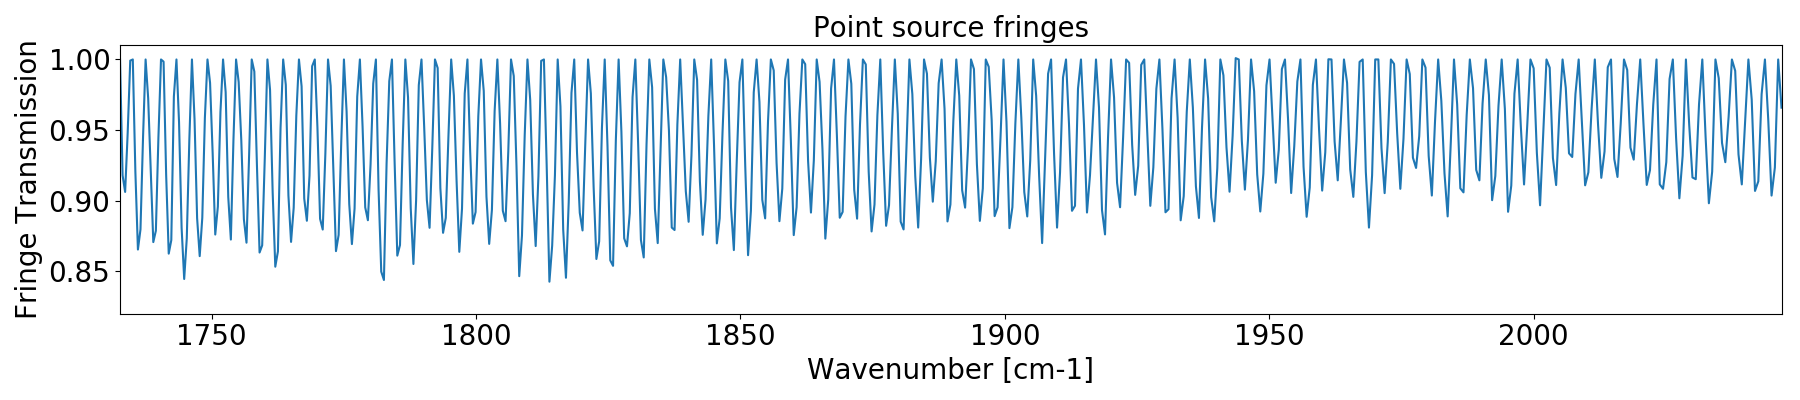

In [5]:
# Construct the spectral grid
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)
# Determine point source centroid
point_source_p1_centroid = funcs.point_source_centroiding(band,point_source_p1_oddevencorr,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='1D')
# Normalize the source signal
point_source_p1_norm = funcs.norm_fringe(point_source_p1_centroid[0],thres=0,min_dist=2,k=3,ext=3)

# Compute zeroth order optical thickness of detector from fringe peak separation
fringepeaks_wavelength     = lambcens[point_source_p1_norm[1]]              # microns
fringepeaks_wavenumber     = np.flipud(10000./fringepeaks_wavelength)       # cm-1
mean_fringepeak_separation = np.mean(np.diff(fringepeaks_wavenumber)[1:-1]) # omit first and last data point
# fit straight line through distance data for comparison
point_popt,point_pcov = curve_fit(funcs.straight_line,fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_fringepeak_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_fringepeak_separation),2) )

# determine optical properties from fringe transmission
sel = np.nonzero(point_source_p1_norm[0])
point_wavenumbers = np.flipud(10000./lambcens[sel])
point_norm_signal = np.flipud((point_source_p1_norm[0]/point_source_p1_norm[2])[sel])

# define scanning window (arbitrarily set to 2*period)
N=1
while point_wavenumbers[N]-point_wavenumbers[0] < 2*mean_fringepeak_separation: N+=1

# Scan fringes
point_R,point_D,point_sigma_R,point_sigma_D = [np.full(len(point_wavenumbers),np.nan) for j in range(4)]

displacements = np.arange(-1,1,0.1) # um
len_numerics = []
for displacement in displacements:
    R0,D0 = 0.10,1/(2*mean_fringepeak_separation) + displacement/10000.
    for i in range(len(point_wavenumbers)-N):
        wvnr_segment = point_wavenumbers[i: N+i].copy()
        array_segment  = point_norm_signal[i: N+i].copy()

        # least-squares fitting
        try: 
            popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
            point_D[i: N+i] = popt[1]

        except RuntimeError: 
            continue
    len_numerics.append(len(np.where(np.abs(np.diff(point_D))*10000.>1)[0]))
len_numerics = np.array(len_numerics)

R0,D0 = 0.10,1/(2*mean_fringepeak_separation) + displacements[np.argmin(len_numerics)]/10000.
for i in range(len(point_wavenumbers)-N):
    wvnr_segment = point_wavenumbers[i: N+i].copy()
    array_segment  = point_norm_signal[i: N+i].copy()

    # least-squares fitting
    try: 
        popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
        TR = funcs.FPfunc_noPhaseShift(wvnr_segment,*popt)

        point_R[i: N+i] = popt[0]
        point_D[i: N+i] = popt[1]
        point_sigma_R[i: N+i] = np.sqrt(np.diag(pcov))[0]
        point_sigma_D[i: N+i] = np.sqrt(np.diag(pcov))[1]
        
    except RuntimeError: 
        continue
# take care about numerics!
if len_numerics[np.argmin(len_numerics)] != 0:
    point_R,point_D,numerics = funcs.cleanRD(point_R,point_D)

#> transmittance function
point_TR = funcs.FPfunc_noPhaseShift(point_wavenumbers,point_R,point_D)

# point source fringe transmission
plt.figure(figsize=(18,4))
plt.title('Point source fringes')
plt.plot(point_wavenumbers,point_norm_signal)
plt.xlim(point_wavenumbers[0],point_wavenumbers[-1])
plt.ylim(0.82,1.01)
plt.xlabel('Wavenumber [cm-1]')
plt.ylabel('Fringe Transmission')
plt.tight_layout()

In [6]:
# MIRI detector optical modeling:
# Transfer-matrix method ("TMM") applied to stack of
# 0. Ambient medium (vacuum)
# 1. AR coating (single layer of zinc sulfide)
# 2. Pure silicon substrate
# 3. Buried contact/electrode
# 4. Arsenic-doped silicon (active) layer
# 5. Pure silicon blocking layer
# 6. aluminum-coated pixel front surface

lambda_vacuum = 5. # wavelength in um
th_0 = 0. # incidence angle in radians

# list of refractive indices
n0 = 1 # ambient medium (vacuum) refractive index
n1 = funcs.indexOfRefractionZnS(lambda_vacuum) # optimal anti-reflection coating refraction coefficient
n2 = funcs.indexOfRefractionSi(lambda_vacuum)  # pure silicon substrate refraction coefficient
n3 = funcs.indexOfRefractionTransCont(lambda_vacuum) # transparent/buried contact/electrode refraction coefficient
n4 = funcs.indexOfRefractionSiAs(lambda_vacuum) # arsenic-doped silicon (active) layer refraction coefficient
n5 = funcs.indexOfRefractionSi(lambda_vacuum) # pure silicon blocking layer refraction coefficient
n6 = funcs.indexOfRefractionAl(lambda_vacuum) # aluminium layer refraction coefficient 

# list of layer thicknesses in um
t0 = np.inf # ambient medium (vacuum) thickness assumed to be semi-infinite
t1 = 0.72   # anti-reflection coating thickness
t2 = 460.5   # pure silicon substrate thickness
t3 = 0.3    # transparent/buried contact/electrode thickness
t4 = 35.    # arsenic-doped silicon (active) layer thickness
t5 = 4.     # pure silicon blocking layer
t6 = np.inf # aluminium thickness assumed to be semi-infinite

n_list = np.array([n0,n1,n2,n3,n4,n5,n6])
d_list = np.array([t0,t1,t2,t3,t4,t5,t6])

In [7]:
total_optical_thickness = (n_list[1:-1]*d_list[1:-1]).sum() # optical_thickness in um
print 'Total optical thickness (based on current assumptions) is {} um'.format(round(total_optical_thickness.real,2))

interp_point_D = interp1d(lambcens[sel],np.flipud(point_D))
print 'From fringe scanning we know that the optical thickness at 5um is {} um'.format(round(interp_point_D(5.)*10000.,2))
print 'We modify the thickness of the silicon substrate slightly to accomodate for the difference between our assumptions and what the data tell us at each wavelength.'

t2 = (interp_point_D(5.)*10000. - (n_list[[1,3,4,5]]*d_list[[1,3,4,5]]).sum().real)/n2.real
print 'The revised thickness of the silicon substrate at 5um is {} um'.format(round(t2,2))
d_list = np.array([t0,t1,t2,t3,t4,t5,t6])

Total optical thickness (based on current assumptions) is 1712.14 um
From fringe scanning we know that the optical thickness at 5um is 1717.72 um
We modify the thickness of the silicon substrate slightly to accomodate for the difference between our assumptions and what the data tell us at each wavelength.
The revised thickness of the silicon substrate at 5um is 462.13 um


In [8]:
R,T,A = funcs.simple_tmm(n_list,d_list,th_0,lambda_vacuum)

print 'Reflectance: {}'.format(round(R,3))
print 'Transmittance: {}'.format(round(T,3))
print 'Absorptance: {}'.format(round(A,3))

Reflectance: 0.741
Transmittance: 0.033
Absorptance: 0.226


### Remarks:
* If we were to picture the detector as one system, the above results tell us that:
    * 30% of the light entering the system is reflected back into the ambient medium.
    * 57% of the light exits the medium through the aluminium, where it is immediately absorbed (see extinction plot below).
    * 13% of the light is absorbed by the detector active layer, where a part of it we detect as electron signal and the rest is converted into phonons (/lattice vibrations), which we do not detect. It is not known what this fraction of measured versus not measured photons exactly is in the active layer.
  
As mentioned, light entering aluminium quickly decays. How quickly it decays can be estimated using the optical properties of aluminium. Recall from Notebook 8 that the absorption coefficient relates to the extinction coefficient as $\alpha = \frac{4\pi k}{\lambda}$, where $k$ is the extinction coefficient.
* We estimate that light entering the aluminium has completely decayed after 0.1um.

<IPython.core.display.Javascript object>


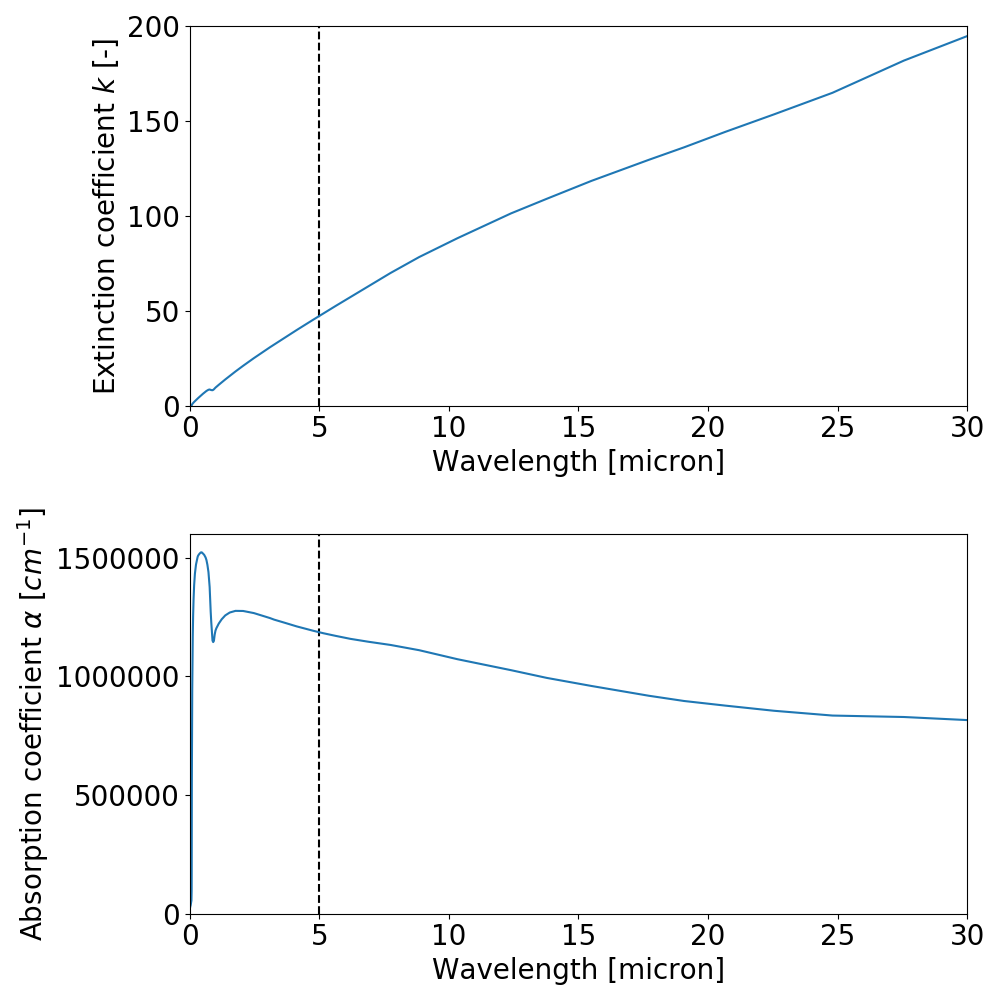

<IPython.core.display.Javascript object>


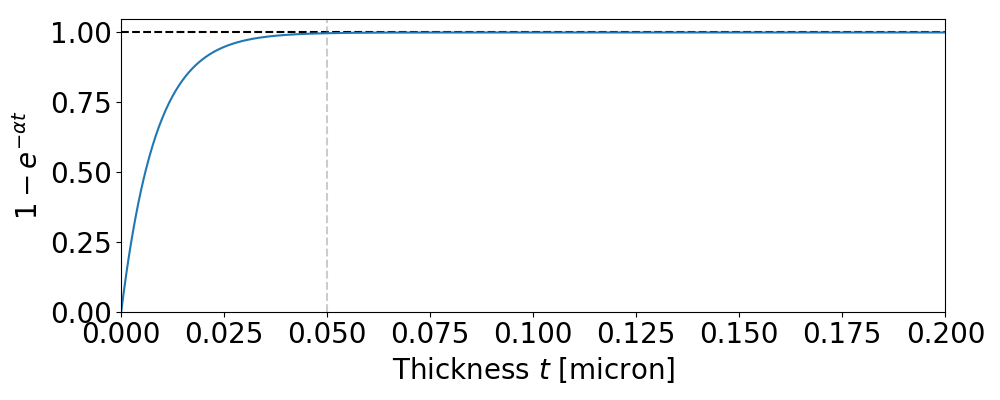

In [9]:
wav_data,k_data = np.genfromtxt(workDir+'extinction_coeff_aluminium.txt',usecols=(0,2),delimiter=',',unpack=True)
abs_coeff = 4*np.pi*k_data/(wav_data*10**-4) # cm-1

fig,axs = plt.subplots(2,1,figsize=(10,10))
axs[0].plot(wav_data,k_data)
axs[0].vlines(5,0,200,linestyle='dashed')
axs[1].plot(wav_data,abs_coeff)
axs[1].vlines(5,0,1.6e6,linestyle='dashed')
axs[0].set_ylim(0,200)
axs[1].set_ylim(0,1.6e6)
axs[0].set_ylabel(r'Extinction coefficient $k$ [-]')
axs[1].set_ylabel(r'Absorption coefficient $\alpha$ [$cm^{-1}$]')
for plot in range(2): 
    axs[plot].set_xlim(0,30)
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

interp_abs_coeff  = interp1d(wav_data,abs_coeff)
layer_thicknesses = np.linspace(0,0.2,1000) # um
intensity_singlepass = 1-np.exp(-interp_abs_coeff(lambda_vacuum)*(layer_thicknesses*10**-4) )

plt.figure(figsize=(10,4))
plt.plot(layer_thicknesses,intensity_singlepass)
plt.hlines(1,0,0.2,linestyle='dashed')
plt.vlines(0.05,0,1.05,'gray',alpha=0.4,linestyle='dashed')
plt.xlim(0,0.2)
plt.ylim(0,1.05)
plt.xlabel(r'Thickness $t$ [micron]')
plt.ylabel(r'$1-e^{-\alpha t}$')
plt.tight_layout()

### Test 1: How does the absorptance vary with wavelength?
We have measured the absorptance of the detector at one wavelength, however this is not enough to tackle the issue of the fringing in MRS spectra. What we need to know is how the absorptance changes with wavelength. So let's carry out the same simulation as before, over the wavelength range of MRS band 1A.

In [12]:
lam_vac = np.linspace(lambcens[sel][0],lambcens[sel][-1],2000)

# list of refractive indices
n1 = funcs.indexOfRefractionZnS(lam_vac)  # optimal anti-reflection coating refraction coefficient
n2 = funcs.indexOfRefractionSi(lam_vac)   # pure silicon substrate refraction coefficient
n3 = funcs.indexOfRefractionBE(lam_vac)   # transparent/buried contact/electrode refraction coefficient
n4 = funcs.indexOfRefractionSiAs(lam_vac) # arsenic-doped silicon (active) layer refraction coefficient
n5 = funcs.indexOfRefractionSi(lam_vac)   # pure silicon blocking layer refraction coefficient
n6 = funcs.indexOfRefractionAl(lam_vac)   # aluminium layer refraction coefficient 

Reflectance,Transmittance,Absorptance = [np.zeros(len(lam_vac)) for i in range(3)]
for i in range(len(lam_vac)):
    n_list = np.array([n0,n1[i],n2[i],n3[i],n4[i],n5[i],n6[i]])
    
    t2 = (interp_point_D(lam_vac[i])*10000. - (n_list[[1,3,4,5]]*d_list[[1,3,4,5]]).sum().real)/n2[i].real
    d_list = np.array([t0,t1,t2,t3,t4,t5,t6])
    
    Reflectance[i],Transmittance[i],Absorptance[i] = funcs.simple_tmm(n_list,d_list,th_0,lam_vac[i])

<IPython.core.display.Javascript object>


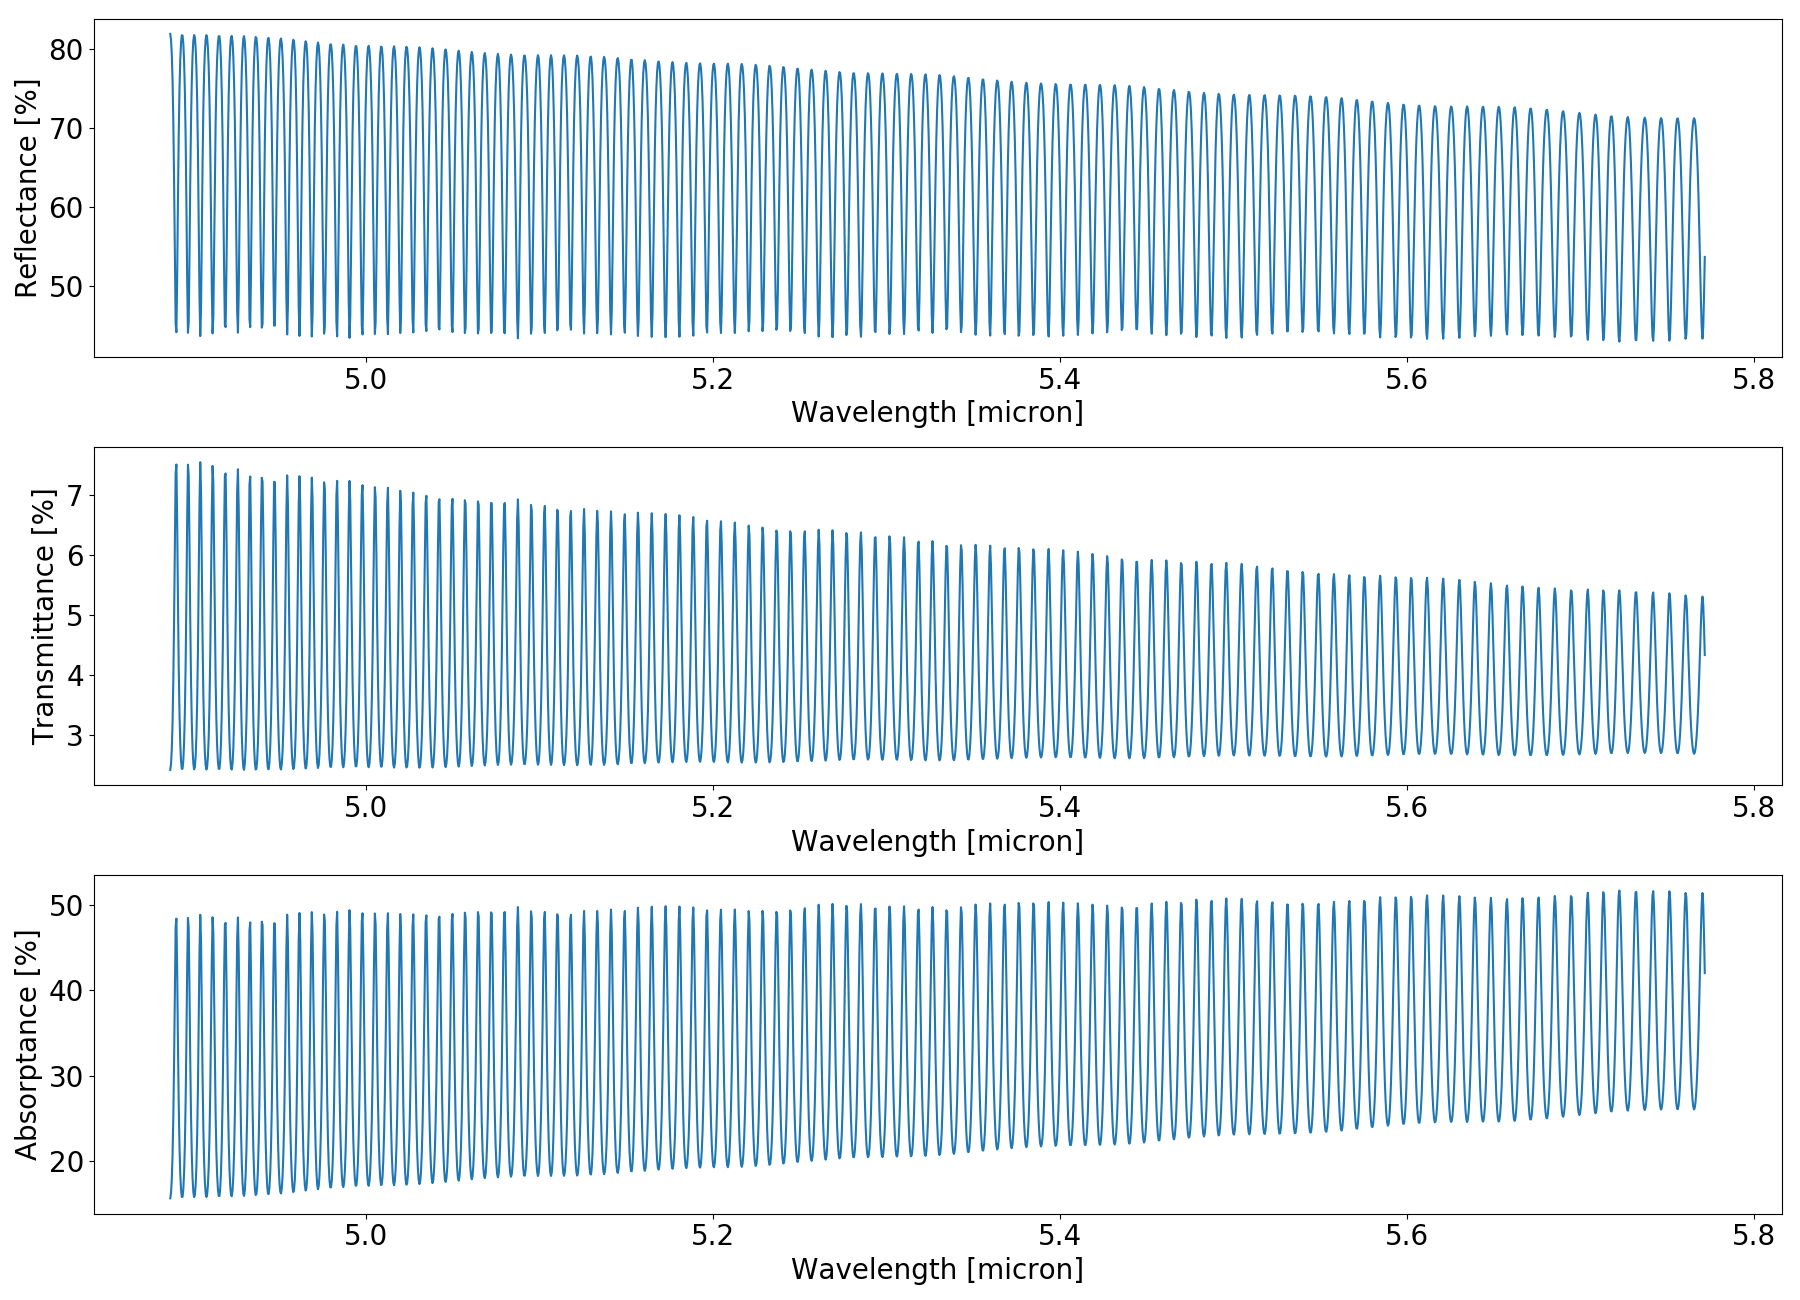

In [13]:
fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].plot(lam_vac,Reflectance*100.)
axs[1].plot(lam_vac,Transmittance*100.)
axs[2].plot(lam_vac,Absorptance*100.)
axs[0].set_ylabel('Reflectance [%]')
axs[1].set_ylabel('Transmittance [%]')
axs[2].set_ylabel('Absorptance [%]')
for plot in range(3): axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* In the absorptance profile we see the characteristic fringe pattern we have studied many times before. Yet why does the beating appear to be partial? I.e. why does there look to be a beating on the fringe peaks (see for instance the reflectance plot) while the amplitude of this one is much smaller on the side of the fringe minima? This, by definition, implies that there is an additional frequency at play, which dampens the effect of the beating.
* We have assumed that internal reflections within all detector layers are coherent, i.e. there is no loss of phase information due to e.g. scattering within the layers. However some scattering is expected to occur within the MIRI detector active layer, caused by the impurities in the doped silicon. Could it be that the active layer acts more akin an incoherent resonator compared to a coherent one? Effectively this would dampen the frequency between the buried contact and the aluminium, making the interference between the anti-reflection coating and the buried contact the dominant frequency (in terms of the observed beating). This conjecture however also affects the high-frequency fringe, given that this one is assumed to occur in the cavity formed by the anti-reflection coating and the aluminium.

Let's normalize the absorptance profile and compare it to the point source data.

<IPython.core.display.Javascript object>


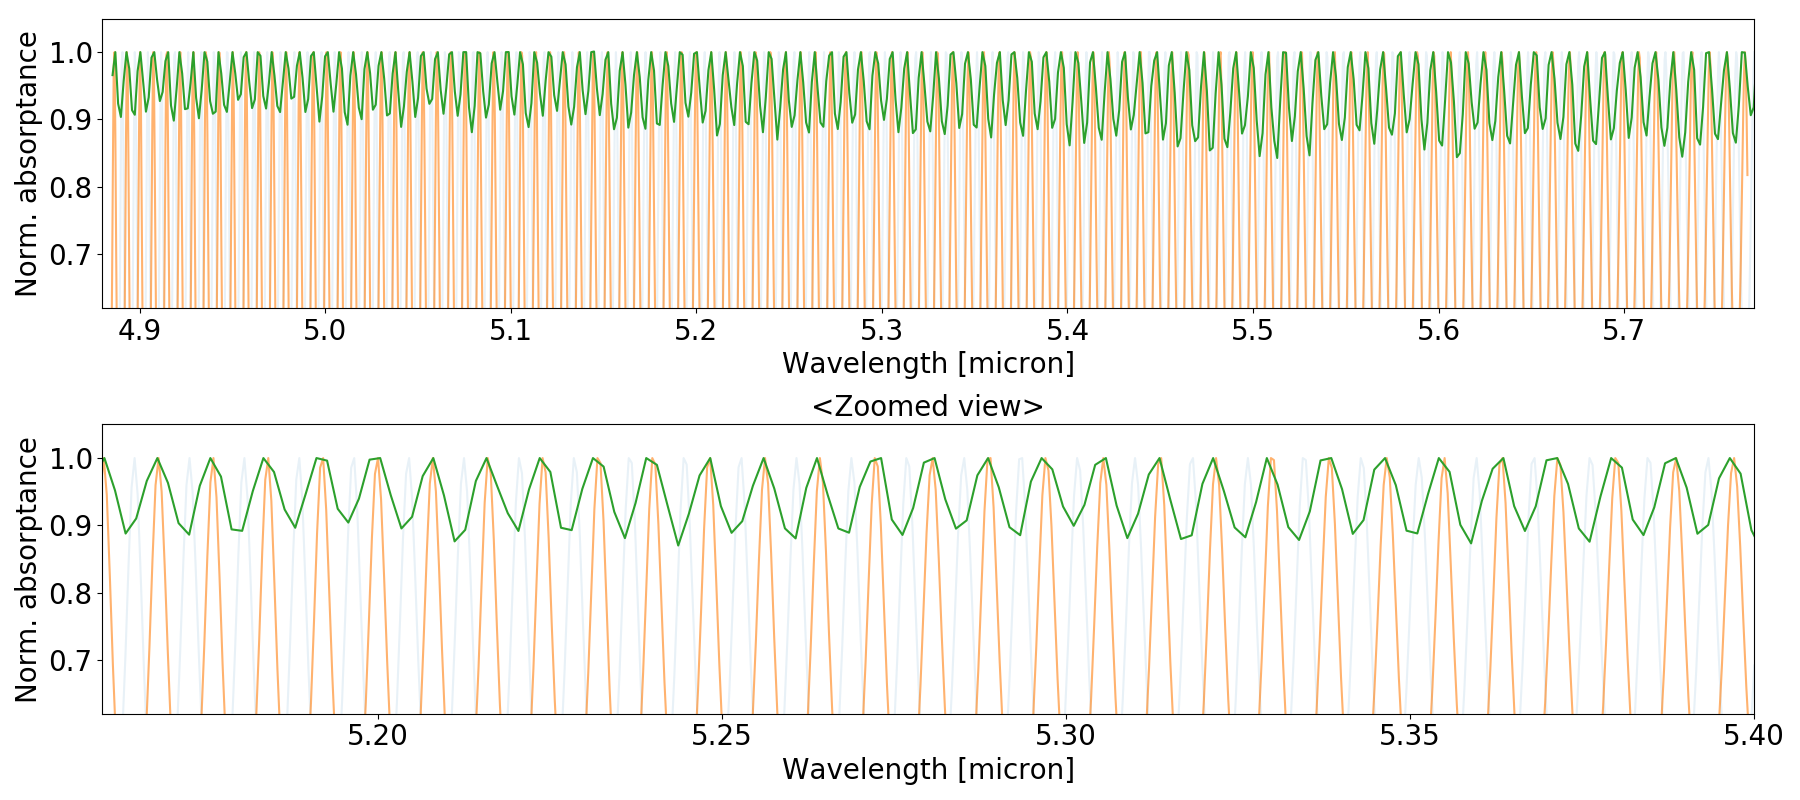

In [22]:
norm_Absorptance = funcs.norm_fringe(Absorptance,thres=0.,min_dist=2)

fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    axs[plot].plot(lam_vac,norm_Absorptance[0]/norm_Absorptance[2],alpha=0.1)
    axs[plot].plot(lam_vac/1.000869387755102,norm_Absorptance[0]/norm_Absorptance[2],alpha=0.6)
    axs[plot].plot(lambcens[sel],np.flipud(point_norm_signal))
    axs[plot].set_ylim(0.62,1.05)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Norm. absorptance')
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.16,5.4)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remark:
* The wavelength scale of the simulated absorptance needs to be scaled by 0.09% to match the point source fringes. This is equivalent to a constant wavenumber shift of 1.2$cm^{-1}$, or 0.00012 $\mu m^{-1}$.
* The normalized absorptance predicts a 30% fringe amplitude, while the data shows a fringe amplitude ~12%.
* The simulation predicts a decreasing fringe amplitude with wavelength. This is a direct result from the reflectivity of the anti-reflection coating decreasing towards the longer wavelengths of MRS band 1A. However we see that the fringe amplitude appears to increase in the data.

## Conclusions:  
There appears to be contradictions at every corner. Though the optical thickness used for the simulation matches that of the data, a small constant phase-shift in wavenumber space is still required to match the fringe peak positions. The fringe contrast of the point source data is much smaller than the simulated fringe contrast, and the latter also yields a beating pattern that looks less like a beating, and more like a mixture of frequencies. Finally, although we expected a fringe amplitude that decreased at longer wavelengths, we found one that increased.
  
Modeling the MIRI detectors can only yield as accurate results as our understanding of the optical system allows. *We need to improve our understanding of the detector via the MIRI fringes and iterate until the model matches the observations.*

## Follow-up question:  
So far we have looked at the extended and point source MTS etalon data, the MTS extended source data, and the MTS point source data. All of the data record sources that are external to MIRI itself, and thus are subject to the optical train leading up to the detector. What if we were to look at a source internal to MIRI? What do the fringes of the MIRI internal calibration source look like? We showed them in Notebook 0. Now let's study them.